Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication

Objectifs :

* Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles

* Fournir à Olist, une segmentation de ses clients avec une description actionable de cette segmantation et sa logique sous-jacente

* Fournir à Olist, une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

Pour plus d'informations sur les données : https://www.kaggle.com/olistbr/brazilian-ecommerce


Dans ce deuxieme notebook du projet, on va essayer de relever le 2eme point des objectifs listés en testant plusieurs modeles de classification non supervisé pour sélectionner le modele approprié pour une segmentation actionnable



In [510]:
# Standards Librairies import

%matplotlib inline
from time import time
from datetime import datetime, timedelta
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

from mpl_toolkits.mplot3d import Axes3D
from math import pi

# Clustering Librairies import

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from yellowbrick.cluster.elbow import kelbow_visualizer
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})
mpl.rcParams["figure.figsize"] = (10, 8)

In [648]:
def aggreagation_cust_df(df):
    
    """cette fonction cree le fichier client en groupant les donnees par 'customer_unique id'
    calcule pour chaque client les RFM ainsi que 6 autres attributs du df 
    retourne les resultats dans un dataframe"""
    
    # nd de jours ecoules du debut de la periode a la date de commande 
    
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    
    df['Recency'] =(df['order_purchase_timestamp'] - df["order_purchase_timestamp"].min()).round('1d')

    df['Recency'] = df['Recency'].astype(str).str.replace(r'\s+days.*', '', regex=True).astype(int)
    
    # Group by customers_unique_id with sum or mean
    
    df = df.groupby("customer_unique_id")\
            .agg(Frequency=("order_id", "nunique"), 
                 #nb_products=("product_id",'count'),
                 nb_items=('quantity', 'sum'),
                 #recent_payment=('payment_value','last'), # montant commande plus recent
                 tot_payment=('payment', 'sum'),
                 Recency=('Recency', 'max'),
                 tot_freight=("freight", "sum"),
                 payment_type=("nb_payment_type" , "mean"), 
                 payment_installment=("tot_payment_installment", "mean"), 
                 rev_score=("review_score", "mean"),
                 SP_State=("customer_state", 'first')  )
                                                    
    
    # Freight ratio and total price
    
    df['Monetary'] = df['tot_payment']+df['tot_freight']
    #df['mean_price_order'] = df['tot_payment']/df['Frequency']
    
    df = df.drop(['tot_payment','tot_freight'], axis=1)
    
    return df
    
    

In [176]:
def clustering_result(df, preprocessor, model):
    
    """cette fonction cree une copie du dataframe deja groupe par customerid, 
    fait la standarisation 
    applique un modele de clustering, calcule le coefficient de silhouette,
    sort le nombre des individus par cluster et
    return les resultats du df groupe par cluster"""
    
    start_time = time()
    
    # creation d'une copie du dataframe
    
    X = df.copy()
    
    # normalisation des donnees

    df_X_scaled = pd.DataFrame(preprocessor.fit_transform(X), 
                                  columns=list(X.columns),
                                  index=X.index)
    
    # Application de model
    
    model = model.fit(df_X_scaled)

    labels = model.labels_
    
    silhouette_coeff = silhouette_score(df_X_scaled, labels)
    
    df_X_scaled['cluster_id'] = labels
    X['cluster_id'] = labels
    
    end_time=time()
    
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) 
    
    print(f"Nombre de clusters: {n_clusters}")
    print(f"Coefficient de Silhouette : {silhouette_coeff:.2f}")
   
    print(f"Nombre de clients sans cluster (noise) : {list(labels).count(-1)}")
    
       
    # Number of clusters in labels, ignoring noise if present.

    # si present, ignorer le label -1  considere comme bruit (noise) par DBSCAN algorithm
    
    if -1 in labels:
        df_X_scaled = df_X_scaled.loc[df_X_scaled['cluster_id']!=-1]
        
    # grouper par cluster
    
    df_X_scaled_grouped = df_X_scaled.groupby("cluster_id").mean().reset_index()
    
    X_grouped = X.groupby("cluster_id").mean().reset_index()
        
    cust_cluster = df_X_scaled["cluster_id"].value_counts()
    for i in range(0,len(cust_cluster)):
        print(f"Nombre de clients par cluster_{cust_cluster.index[i]} : {cust_cluster.values[i]}")
        
    
    print(f"temps d'execution : {(end_time - start_time):.2f} secondes")
   

    return df_X_scaled_grouped, X, df_X_scaled 

    
    

In [532]:

def radar_plot (df, preprocessor):
    
    """
    Cette fonction plot en radar la moyenne des variables par clustering deja groupe dans un dataframe 
    resultant de la fonction custering_results et contenant la variable cluster_id

    Parameters:
    -----------------
        df : dataframe to plot resultat du clustering_result avec une variable cluster_id
                        
    """
     
    # couleur des clusters sur le radarplot
    
    sns_palette = sns.color_palette("Set2", df["cluster_id"].nunique())
    colors = {label : color for label, color in zip(df["cluster_id"].unique(), sns_palette.as_hex())}
    
    
    # Data Standarization
    
    df_to_plot_std = pd.DataFrame(preprocessor.fit_transform(df), 
                                  columns=list(df.columns),
                                  index=df.index)
     
    # Nombre de variables 
    
    variables = list(df_to_plot_std)[1:]
    N = len(variables)
    

    # Calcul des angles de chaque axe (plot / Nombre de variables)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    
    fig = plt.figure(1, figsize=(16, 15))
    
    for i, cluster in enumerate(df['cluster_id'].unique()):
        
        ax = fig.add_subplot(2, 2, i + 1, polar=True)
        
        
        # liste des valeurs de chaque cluster : on ajoute la premiere valeur a la fin aussi pour fermer le cercle :
        
        values = list(df_to_plot_std.drop('cluster_id',axis=1).loc[cluster].values)
        values += values[:1]
 
        
        ax.set_title(cluster, color=colors[cluster], fontdict={ "fontsize": 15, "fontweight": "bold" })
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
        # Une variable/axe + ajout labels 
        
        plt.xticks(angles[:-1], variables, color="grey", size=8)
        ax.set_xticklabels(variables, size=12)
        ax.set_rlabel_position(0)
        
        #  ylabels
      
        plt.yticks([-0.25, 0, 0.25, 0.5,0.75,1], ["-0.25", "0","0.25", "0.5","0.75","1"], color="grey", size=10)
        plt.ylim(-0.25, 1)
            
                
        # Plot data
        #ax.plot(angles, values, colors[cluster], "o-", linewidth=1, linestyle="solid")
        
        ax.plot(angles, values, colors[cluster],  linewidth=1, linestyle="solid")

        # Fill area
        ax.fill(angles, values, colors[cluster], alpha=.25)


In [533]:
# Radar plot

def radar_plot_std (df, preprocessor):
    
    """
    Cette fonction plot en radar la moyenne des variables par clustering deja groupe dans un dataframe 
    resultant de la fonction custering_results et contenant la variable cluster_id

    Parameters:
    -----------------
        df : dataframe to plot resultat du clustering_result avec une variable cluster_id
                        
    """
     
    # couleur des clusters sur le radarplot
    
    sns_palette = sns.color_palette("Set2", df["cluster_id"].nunique())
    colors = {label : color for label, color in zip(df["cluster_id"].unique(), sns_palette.as_hex())}
    
    
    # Data Standarization
    
    df_to_plot_std = pd.DataFrame(preprocessor.fit_transform(df), 
                                  columns=list(df.columns),
                                  index=df.index)
     
    # Nombre de variables 
    
    variables = list(df_to_plot_std)[1:]
    N = len(variables)
    

    # Calcul des angles de chaque axe (plot / Nombre de variables)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    
    fig = plt.figure(1, figsize=(16, 15))
    
    for i, cluster in enumerate(df['cluster_id'].unique()):
        
        ax = fig.add_subplot(2, 2, i + 1, polar=True)
        
        
        # liste des valeurs de chaque cluster : on ajoute la premiere valeur a la fin aussi pour fermer le cercle :
        
        values = list(df_to_plot_std.drop('cluster_id',axis=1).loc[cluster].values)
        values += values[:1]
 
        
        ax.set_title(cluster, color=colors[cluster], fontdict={ "fontsize": 15, "fontweight": "bold" })
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
        # Une variable/axe + ajout labels 
        
        plt.xticks(angles[:-1], variables, color="grey", size=8)
        ax.set_xticklabels(variables, size=12)
        ax.set_rlabel_position(0)
        
        #  ylabels
      
                
        plt.yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2], ["-1.5", "-1", "-0.5", "0", "0.5", "1", "1.5", "2"], color="black",
                   size=8)
        plt.ylim(-1.5, 2)
 
        
        # Plot data
        #ax.plot(angles, values, colors[cluster], "o-", linewidth=1, linestyle="solid")
        
        ax.plot(angles, values, colors[cluster],  linewidth=1, linestyle="solid")

        # Fill area
        ax.fill(angles, values, colors[cluster], alpha=.25)


In [349]:
# fonction heat map importance des attributs

def heat_map_att(df, preprocessor):
    
    # Data Standarization

    df_std = pd.DataFrame(MinMaxScaler().fit_transform(df), 
                                  columns=list(df.columns),
                                  index=df.index)
    
    
    plt.figure(figsize=(8, 4))
    ax = sns.heatmap(data=df_std, annot=True, fmt='.2f', cmap='RdYlGn')
    ax.set_ylim(len(df_std), 0)
    plt.ylabel("")
    plt.title("Importance des attributs", fontsize=15)


In [372]:
def projection_3d_segments(df) :
    """
    Graphique montrant les différents clients associés à leur cluster respectif
    rfmTable(pd.DataFrame): Table de résultats
    label_score(str): nom de la segmentation
    colors(list): liste de couleurs

    """
    
    # couleur des clusters 
    
    sorted_cluster = np.sort(df['cluster_id'].unique())
    sns_palette = sns.color_palette("Set2", df["cluster_id"].nunique())
    colors = {label : color for label, color in zip(sorted_cluster , sns_palette.as_hex())}
    
    fig = plt.figure(1, figsize=(10, 8))

    dx = fig.add_subplot(111, projection='3d')
    
    # Pour chaque segment, scatter plot des individus avec code couleur
    
    
    
    for i, segment in enumerate(sorted_cluster):
        
        dx.scatter(df[df['cluster_id'] == segment].Recency,
                   df[df['cluster_id'] == segment].Frequency,
                   df[df['cluster_id'] == segment].Monetary,
                   label=segment,
                   s=50,
                   c=colors[segment])
        
    # Titre des axes et titre graphique

    dx.set_xlabel("Recency")
    dx.set_ylabel("Frequency")
    dx.set_zlabel("Monetary")
    plt.title("Représentation 3D des différents individus dans chaque segment")
    
    # legende
    
    plt.legend()
    plt.show()

In [625]:
def tsne_graph(df, preprocessor, model, perplex):
    
    """cette fonction cree une copie du dataframe deja groupe par customerid, 
    fait la standarisation 
    applique un modele de clustering, fit la reduction tsne et 
    illustre les resultats graphiquement"""
    
    start_time = time()
    
    # creation d'une copie du dataframe
    
    X = df.copy()
    
    # Application de model
    
    model = model.fit(X)

    labels = model.labels_
    
    std_scale = MinMaxScaler().fit(X)
    
    X_scaled = std_scale.transform(X)


    tnse = TSNE(n_components=2, perplexity = perplex, init='pca')  
    x_tsne = tnse.fit_transform(X_scaled)

    x_tsne_df = pd.DataFrame(x_tsne,  columns=["composante_1",
                                                   "composante_2"])
    x_tsne_df["clusters"] = labels


    end_time = time()
    print(f"--- %s seconds ---{(end_time - start_time)}")


    # Liste du nombre de clusters à tester
    palette = sns.color_palette("Set2", 4)
    colors_2 = palette.as_hex()

    fig = plt.figure(1, figsize = (10, 8))
 
    dx = fig.add_subplot(111)

    for i in range(4):
        dx.scatter(x_tsne_df[x_tsne_df.clusters == i]["composante_1"],
                       x_tsne_df[x_tsne_df.clusters == i]["composante_2"],
                       c=colors_2[i],
                       label='Cluster ' + str(i+1),
                       s=50)
    
    # Titres des axes
    dx.set_xlabel("Composante_1")
    dx.set_ylabel("Composante_2")
    dx.set_title("Projection 2D par TSNE")

# plt.savefig('TSNE RFM', dpi=200, bbox_inches='tight')
# plt.show()

In [180]:
# Import cleaning total file

df = pd.read_csv("df_reduit.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100084 entries, 0 to 100083
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  100084 non-null  object 
 1   order_purchase_timestamp  100084 non-null  object 
 2   product_id                100084 non-null  object 
 3   quantity                  100084 non-null  int64  
 4   customer_unique_id        100084 non-null  object 
 5   customer_state            100084 non-null  float64
 6   nb_payment_type           100084 non-null  float64
 7   tot_payment_installment   100084 non-null  float64
 8   payment_value             100084 non-null  float64
 9   review_score              100084 non-null  int64  
 10  payment                   100084 non-null  float64
 11  freight                   100084 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 9.2+ MB


## Creation fichier client  

In [649]:
cust_file = aggreagation_cust_df(df)

In [650]:
cust_file.head()

,Frequency,nb_items,Recency,payment_type,payment_installment,rev_score,SP_State,Monetary
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1,602,1.0,8.0,5.0,1.0,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,599,1.0,1.0,4.0,1.0,27.19
0000f46a3911fa3c0805444483337064,1,1,176,1.0,8.0,3.0,0.0,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,1,392,1.0,4.0,4.0,0.0,43.62
0004aac84e0df4da2b147fca70cf8255,1,1,425,1.0,6.0,5.0,1.0,196.89


In [651]:
cust_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92755 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Frequency            92755 non-null  int64  
 1   nb_items             92755 non-null  int64  
 2   Recency              92755 non-null  int32  
 3   payment_type         92755 non-null  float64
 4   payment_installment  92755 non-null  float64
 5   rev_score            92755 non-null  float64
 6   SP_State             92755 non-null  float64
 7   Monetary             92755 non-null  float64
dtypes: float64(5), int32(1), int64(2)
memory usage: 6.0+ MB


## Segmentation RFM

RFM est un acronyme pour Recence, Fréquence et Montant (Recency, Frequency, Monetary en anglais).

La segmentation RFM prend en compte donc de :  
La Récence (date de la dernière commande)  
La Fréquence qui est le nombre d'achat sur une période déterminée. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevée et plus le client est engagé.   
Le Montant qui est la somme totale qu'un client dépense sur une période donnée 

In [182]:
# fichier client avec seulement RFM comme attributs

cust_RFM = cust_file[ ['Recency', 'Frequency', 'Monetary'] ]

### Test des modeles de classification non supervisé

In [183]:
# Creation d'un echantillon de dataset comme certains modeles prennent beaucoup du temps 

df_RFM_sample = cust_RFM.sample(n=20000, random_state=0)

### KMeans

#### Détermination du meilleur K pour Kmeans : methode Elbow 



Critère d'Elbow :

Cette methode via la librairie yellowbrick, affiche le nombre de clusters vs la somme des distances quadratiques de tous les points au centre de leurs clusters et identifie un "elbow" (coude) dans le graphique - ce point représentant le nombre optimal de clusters

Coefficient de silhouette
En partitionnement de données (clustering), le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique.

Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec le points des autres groupes voisins (séparation), normalisée par la valeur maximale. Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. Il varie de -1 (pire classification) à 1 (meilleur classification)



In [639]:
# Standarisation

scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, df_RFM_sample.columns)])


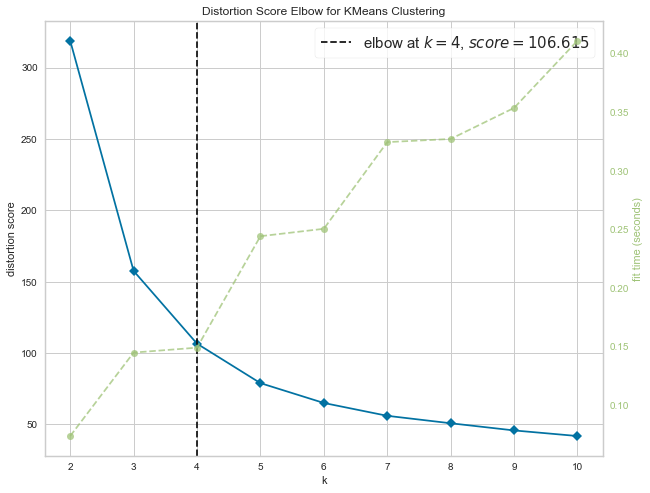

In [194]:
# Elbow method


# kelbowvisualizer pour K (2,15)

kmeans_visualizer = Pipeline([
    ("preprocessor",  preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(random_state=0),K=(2,15))) ])

kmeans_visualizer.fit(df_RFM_sample)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()
None



Grâce à la méthode du coude basée sur le score de distorsion (somme moyenne des carrés des distances aux centres), une segementation en  𝐾=4  clusters serait la meilleure option.

In [210]:
df_RFM_sample_Kmeans = clustering_result(df_RFM_sample, MinMaxScaler(), KMeans(n_clusters=K, random_state=0))

Nombre de clusters: 4
Coefficient de Silhouette : 0.51
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_0 : 5744
Nombre de clients par cluster_2 : 5454
Nombre de clients par cluster_3 : 5155
Nombre de clients par cluster_1 : 3647
temps d'execution : 7.94 secondes


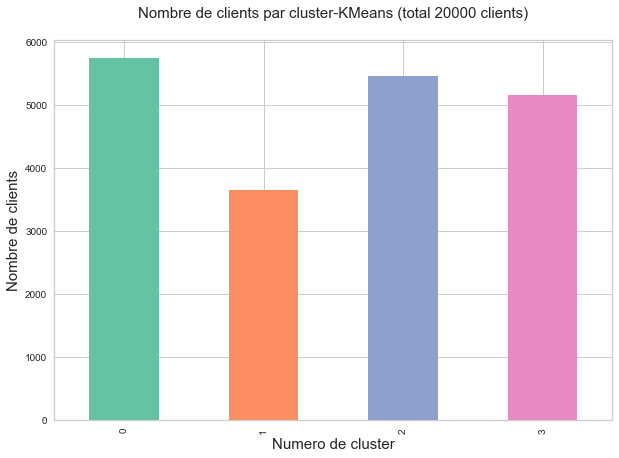

In [586]:


fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

#bar plot

palette = sns.color_palette("Set2", df_RFM_sample_Kmeans[1]["cluster_id"].nunique())

df_RFM_sample_Kmeans[1]["cluster_id"].value_counts().sort_index().plot(kind='bar' , color = palette)

ax.set_xlabel("Numero de cluster", fontsize = 15)
ax.set_ylabel("Nombre de clients", fontsize = 15)
plt.title("Nombre de clients par cluster-KMeans (total 20000 clients)\n", fontsize = 15)


 


plt.savefig("Nombre de clients par cluster-KMeans", dpi=200, bbox_inches='tight')

        
        

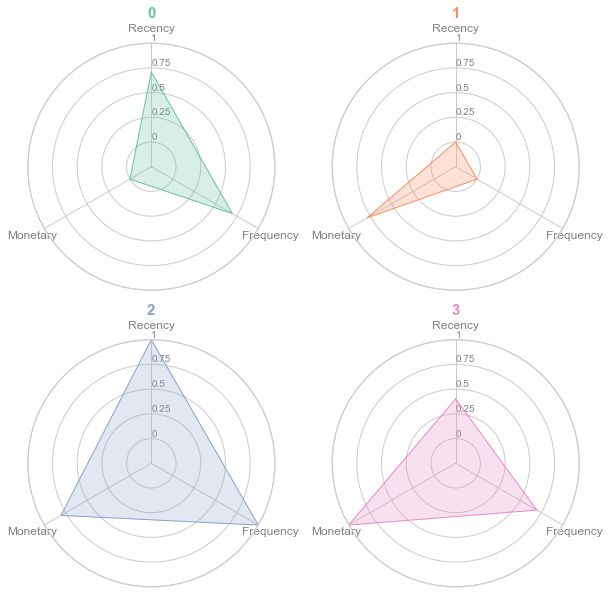

In [212]:
 radar_plot(df_RFM_sample_Kmeans[0], MinMaxScaler())

## Agglomerative clustering

--- %s seconds ---33.9905960559845


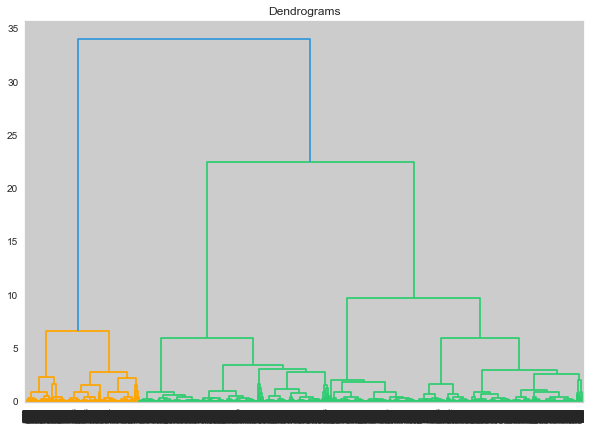

In [628]:
# dendrom pour nombre de clusters optimal

X = df_RFM_sample.copy()
    
# normalisation des donnees

df_X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), 
                                  columns = list(X.columns),
                                  index = X.index)

start_time=time()
    

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_X_scaled, method='ward'))

end_time = time()
print(f"--- %s seconds ---{(end_time - start_time)}")

plt.savefig('dendogramme std', dpi=200, bbox_inches='tight')

plt.show()

Nombre de clusters optimal est 3 ou 4. Voyons avec Elbowmethod

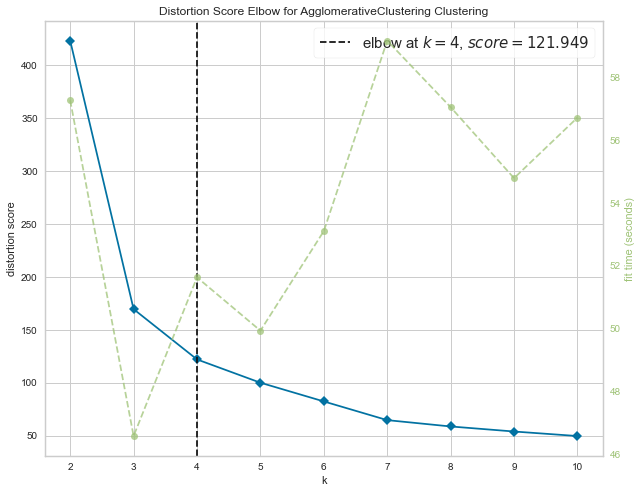

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [200]:
# AgglomerativeClustering Elbow method pour n_clusters optimal

n_clusters=[2,3,4,5,6,7,8,9,10,12]
agg_cluster = AgglomerativeClustering(n_clusters = n_clusters)
agg_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(agg_cluster, K=n_clusters))])
agg_visualizer.fit(df_RFM_sample)
agg_visualizer.named_steps['kelbowvisualizer'].show()


Nombre de cluter optimal est 4. Comment sont-ils repartis?

In [209]:
df_RFM_sample_agg = clustering_result(df_RFM_sample, MinMaxScaler(),  AgglomerativeClustering(n_clusters=K_agg))

Nombre de clusters: 4
Coefficient de Silhouette : 0.43
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_2 : 6797
Nombre de clients par cluster_1 : 5961
Nombre de clients par cluster_0 : 4083
Nombre de clients par cluster_3 : 3159
temps d'execution : 63.89 secondes


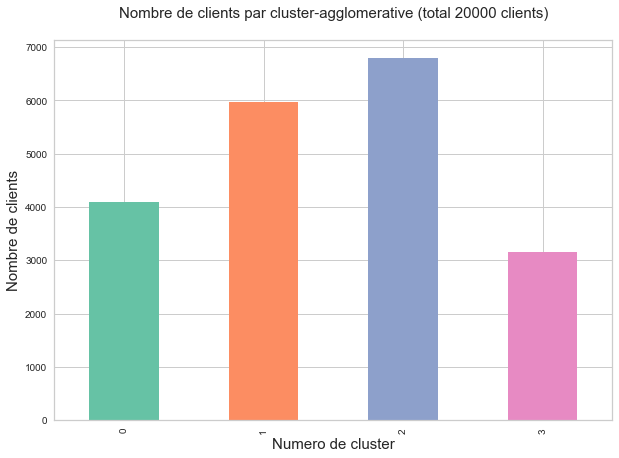

In [589]:


fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

#bar plot

palette = sns.color_palette("Set2", df_RFM_sample_agg[1]["cluster_id"].nunique())

df_RFM_sample_agg[1]["cluster_id"].value_counts().sort_index().plot(kind='bar' , color = palette)

ax.set_xlabel("Numero de cluster", fontsize = 15)
ax.set_ylabel("Nombre de clients", fontsize = 15)
plt.title("Nombre de clients par cluster-agglomerative (total 20000 clients)\n", fontsize = 15) 


plt.savefig("Nombre de clients par cluster-agg", dpi=200, bbox_inches='tight')



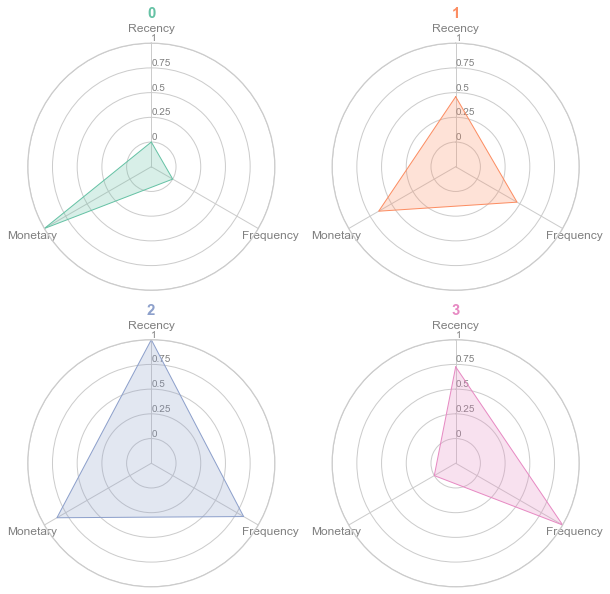

In [213]:
 radar_plot(df_RFM_sample_agg[0], MinMaxScaler())

### La classification avec le modele agglometrative clustering n'est pas loin de celle avec kmeans. Cependant, le temps d'execution est 8 fois plus long que kmeans et le coefficient de silhouette est plus petit 

### DBSCAN CLUSTERING

In [591]:
df_RFM_sample_dbscan = clustering_result(df_RFM_sample, MinMaxScaler(),  DBSCAN(eps = 0.4, min_samples = 100) )

Nombre de clusters: 1
Coefficient de Silhouette : 0.73
Nombre de clients sans cluster (noise) : 3
Nombre de clients par cluster_0 : 19997
temps d'execution : 17.46 secondes


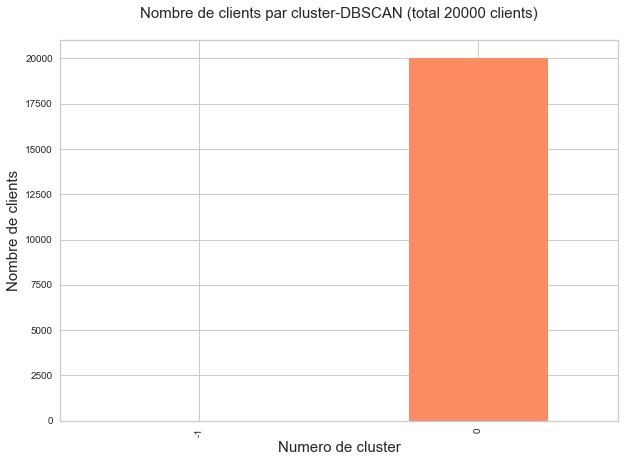

In [592]:


fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

#bar plot

palette = sns.color_palette("Set2", df_RFM_sample_dbscan[1]["cluster_id"].nunique())

df_RFM_sample_dbscan[1]["cluster_id"].value_counts().sort_index().plot(kind='bar' , color = palette)

ax.set_xlabel("Numero de cluster", fontsize = 15)
ax.set_ylabel("Nombre de clients", fontsize = 15)
plt.title("Nombre de clients par cluster-DBSCAN (total 20000 clients)\n", fontsize = 15) 


plt.savefig("Nombre de clients par cluster-DBSCAN-sample100", dpi=200, bbox_inches='tight')

silhouette_score requires more than 1 cluster labels. This causes the error. The error message is clear.

In [225]:
df_RFM_sample_dbscan = clustering_result(df_RFM_sample, StandardScaler(),  DBSCAN(eps = 0.4, min_samples = 100) )

Nombre de clusters: 1
Coefficient de Silhouette : 0.68
Nombre de clients sans cluster (noise) : 1266
Nombre de clients par cluster_0 : 18734
temps d'execution : 6.85 secondes


In [227]:
df_RFM_sample_dbscan = clustering_result(df_RFM_sample, StandardScaler(),  DBSCAN(eps = 0.40, min_samples = 10) ) 

Nombre de clusters: 4
Coefficient de Silhouette : 0.46
Nombre de clients sans cluster (noise) : 225
Nombre de clients par cluster_0 : 19283
Nombre de clients par cluster_1 : 440
Nombre de clients par cluster_2 : 41
Nombre de clients par cluster_3 : 11
temps d'execution : 7.19 secondes


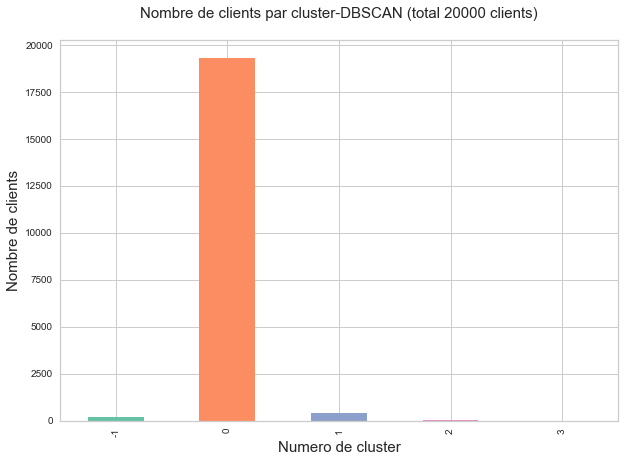

In [590]:


fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

#bar plot

palette = sns.color_palette("Set2", df_RFM_sample_dbscan[1]["cluster_id"].nunique())

df_RFM_sample_dbscan[1]["cluster_id"].value_counts().sort_index().plot(kind='bar' , color = palette)

ax.set_xlabel("Numero de cluster", fontsize = 15)
ax.set_ylabel("Nombre de clients", fontsize = 15)
plt.title("Nombre de clients par cluster-DBSCAN (total 20000 clients)\n", fontsize = 15) 


plt.savefig("Nombre de clients par cluster-DBSCAN", dpi=200, bbox_inches='tight')

### Avec DBSCAN, en variant les hyperparametres et meme la technique de standardisation, on arrive pas a obtenir une classification pertinente : soit une seule classe soit le nombre de clients par classe est tres faible comme ci-dessus (le cluster -1 correspond aux clients non classes qualifie comme noise)


## En conclusion, le modele Kmeans est le plus approprie pour la segmentation. Dans la suite, j'utilise donc Kmeans pour la segmentation sur tout le dataset

# K-means sur le dataset total

### Est ce que K optimum change avec la taille du dataset?

In [631]:
# Standarisation

scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, cust_RFM.columns)])

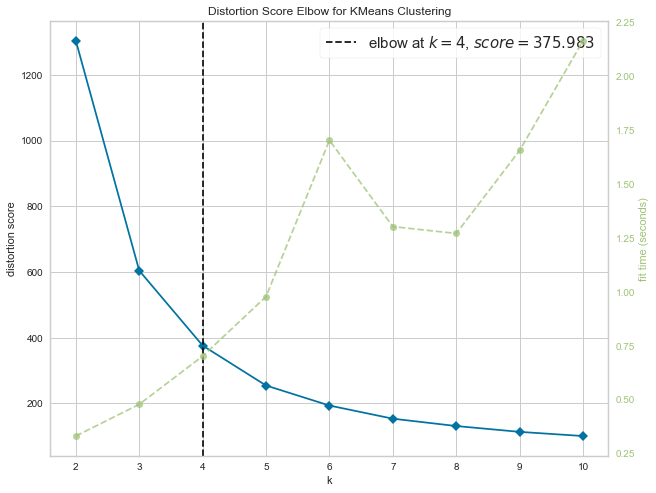

In [229]:
# kelbowvisualizer pour K (2,15)

kmeans_visualizer = Pipeline([
    ("preprocessor",  preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(random_state=0),K=(2,15))) ])

kmeans_visualizer.fit(cust_RFM)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()
None

Ca ne change pas: k optimum est toujours 4

## Coefficient de silhouette


Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

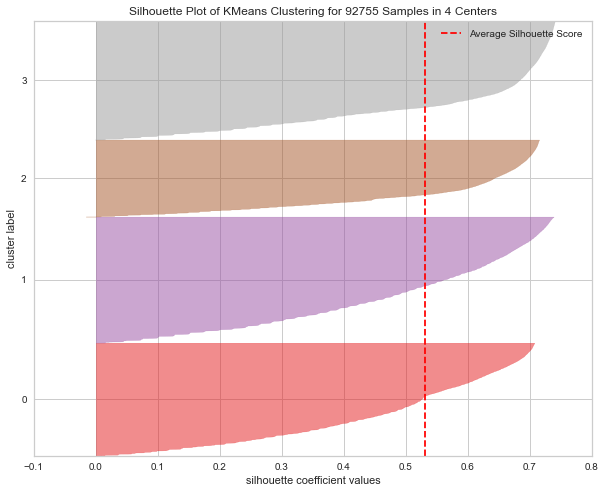

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92755 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [230]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])

silhouette_visualizer.fit(cust_RFM)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

### Distances intercluster

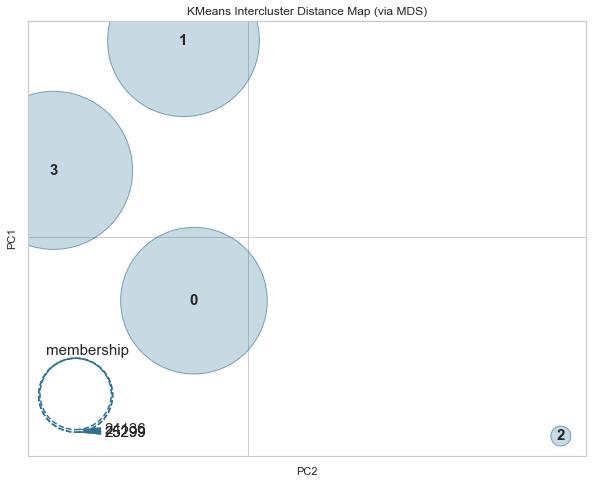

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [638]:

# Intercluster distance Map with best k


distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K, random_state = 0)))])

distance_visualizer.fit(cust_RFM)
distance_visualizer.named_steps['distancevisualizer'].show()

### Analyse des différents clusters

In [364]:
df_RFM_Kmeans = clustering_result(cust_RFM, MinMaxScaler(), KMeans(n_clusters=K, random_state=0))

Nombre de clusters: 4
Coefficient de Silhouette : 0.53
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_3 : 26893
Nombre de clients par cluster_1 : 25299
Nombre de clients par cluster_0 : 24136
Nombre de clients par cluster_2 : 16427
temps d'execution : 142.30 secondes


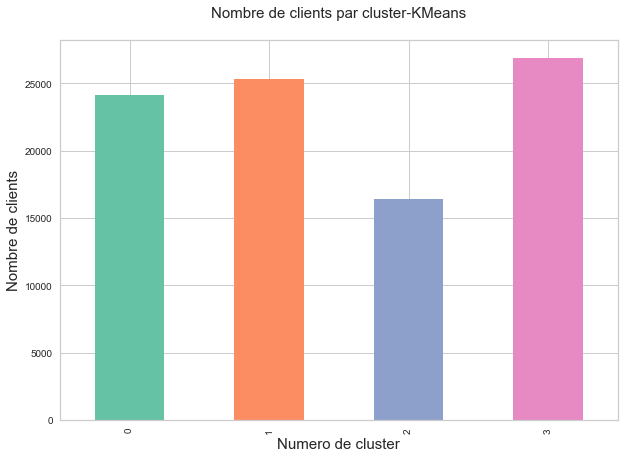

In [593]:


fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

#bar plot

palette = sns.color_palette("Set2", df_RFM_Kmeans[1]["cluster_id"].nunique())

df_RFM_Kmeans[1]["cluster_id"].value_counts().sort_index().plot(kind='bar' , color = palette)

ax.set_xlabel("Numero de cluster", fontsize = 15)
ax.set_ylabel("Nombre de clients", fontsize = 15)
plt.title("Nombre de clients par cluster-KMeans\n", fontsize = 15)


 


plt.savefig("Nombre de clients par cluster-KMeans-tot", dpi=200, bbox_inches='tight')

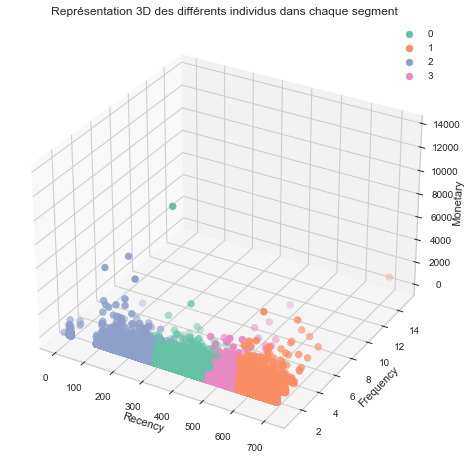

<Figure size 720x576 with 0 Axes>

In [388]:
# %matplotlib widget

projection_3d_segments(df_RFM_Kmeans[1])
# what iplt.legend(['A','B','C', 'D'])

plt.savefig("3D plot RFM", dpi=200, bbox_inches='tight')
plt.show()

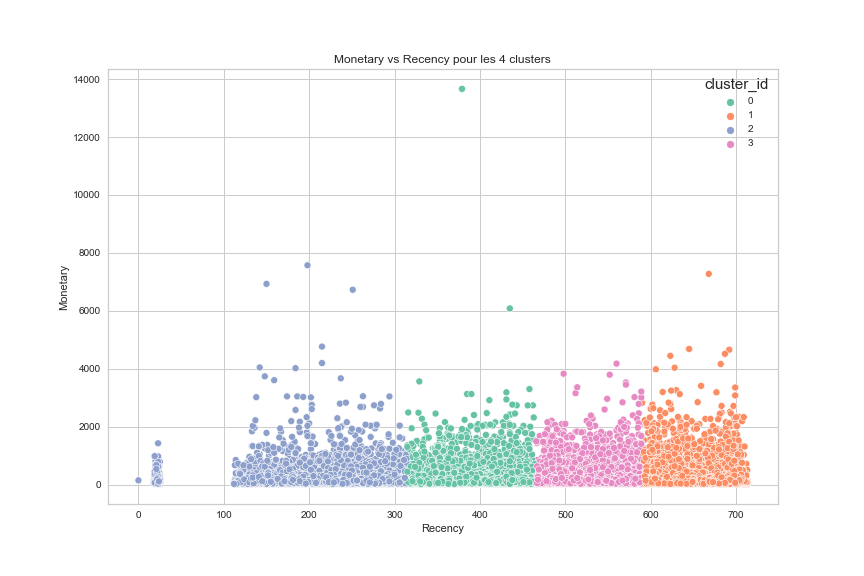

In [307]:
plt.figure(figsize=(12, 8))

# couleur des clusters 

sns_palette = sns.color_palette("Set2", df_RFM_Kmeans[1]["cluster_id"].nunique())

# plot

sns.scatterplot(df_RFM_Kmeans[1]['Recency'],df_RFM_Kmeans[1]['Monetary'], hue=df_RFM_Kmeans[1]['cluster_id'], 
                palette=sns_palette)
plt.title('Monetary vs Recency pour les 4 clusters')
plt.savefig("Monetary vs Recency pour les 4 clusters", dpi=200, bbox_inches='tight')
plt.show()

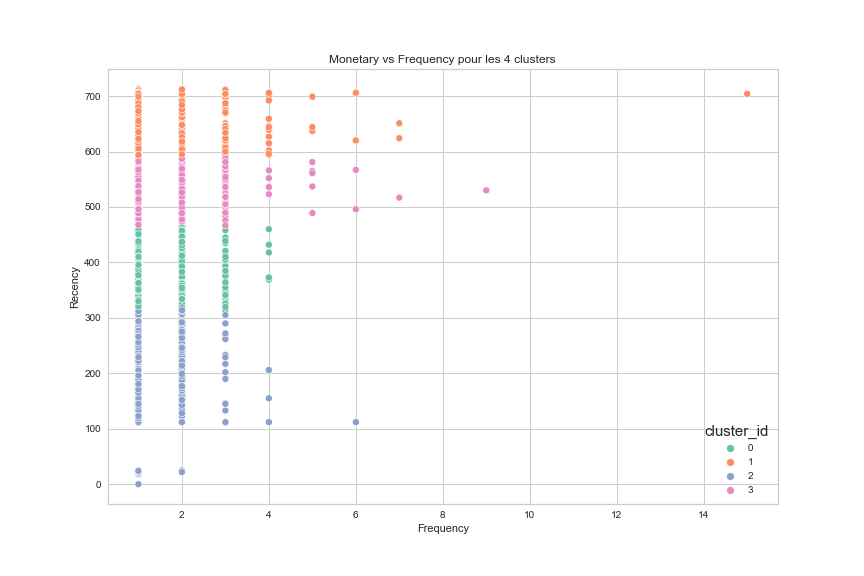

In [316]:
plt.figure(figsize=(12, 8))

# couleur des clusters 

sns_palette = sns.color_palette("Set2", df_RFM_Kmeans[1]["cluster_id"].nunique())

# plot

sns.scatterplot(df_RFM_Kmeans[1]['Frequency'],df_RFM_Kmeans[1]['Recency'], hue=df_RFM_Kmeans[1]['cluster_id'], 
                palette=sns_palette)
plt.title('Monetary vs Frequency pour les 4 clusters')
plt.savefig("Monetary vs Frequency pour les 4 clusters", dpi=200, bbox_inches='tight')
plt.show()

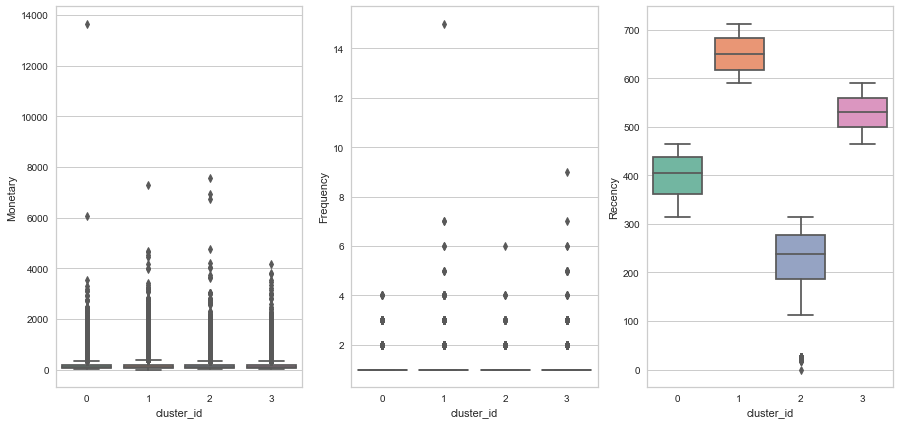

In [329]:
fig = plt.figure(1, figsize=(15, 7))

plt.subplot(131)
sns.boxplot(x='cluster_id', y= 'Monetary', data=df_RFM_Kmeans[1], palette=sns_palette)
#plot
plt.subplot(132)
sns.boxplot(x='cluster_id', y = 'Frequency', data=df_RFM_Kmeans[1], palette=sns_palette)  #, showfliers=False)

# plot
plt.subplot(133)
sns.boxplot(x='cluster_id', y='Recency', data=df_RFM_Kmeans[1], palette=sns_palette)

plt.savefig("boxplot pour les 4 clusters", dpi=200, bbox_inches='tight')
plt.show()

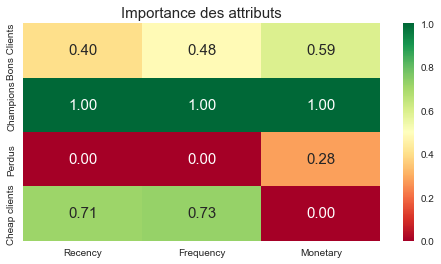

In [350]:
heat_map_att(df_RFM_Kmeans[0], MinMaxScaler())
plt.savefig("Importance des attributs RFM", dpi=200, bbox_inches='tight')
plt.show()

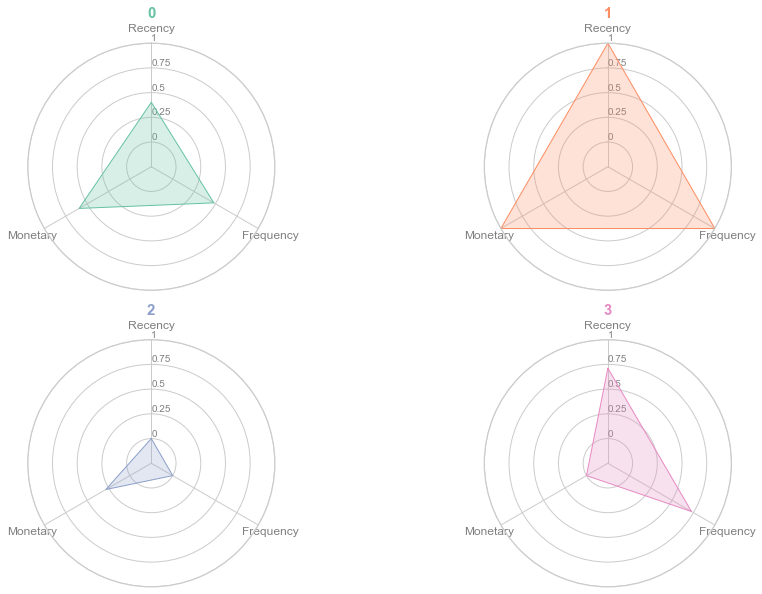

In [402]:
radar_plot(df_RFM_Kmeans[0], MinMaxScaler())

plt.savefig("radar plot RFM", dpi=200, bbox_inches='tight')

## En se basant sur les plots, on peut déduire :

### <font color=#66c2a5> Cluster 0 - Bons clients : achat midterme, plus d'une fois pour un bon montant.   
<font color=#66c2a5> Action de développement de la fréquence d'achat ou du montant par commande : coupler les actions de fidélisation et les promotions  
    
### <font color=#fc8d62> Cluster 1 - tres bon clients : ont acheté récemment, plus d'une fois pour une bonne somme d'argent.  
<font color=#fc8d62>  Action de fidélisation avec une carte premium, invitations VIP, etc. 
    
### <font color=#8da0cb> Cluster 2 - clients inactifs/Perdus : pas d'achat fréquent ni récent et pour une somme modique d'argent.  
<font color=#8da0cb> Action : Ne pas passer trop de temps à essayer de les récupérer. Séparer les dans une liste et cibler-les avec une compagne de reductions. Enlever ensuite tous ceux qui n'ont pas réagi.
    
### <font color=#e78ac3> Cluster 3 : Cheap clients : ont acheté récemment, plus d'une fois mais pour un faible montant.
<font color=#e78ac3> Action : Concentrez-vous sur l'augmentation de la monétisation grâce à des recommandations de produits basées sur des achats antérieurs et des promotions liées à des seuils de dépenses


### Reprend Kmeans en ajoutant des attributs (review_score)

In [484]:
df_RFM_rev = cust_file[['Recency','Frequency','Monetary', 'rev_score']]


In [512]:
df_RFM_rev_kmeans = clustering_result(df_RFM_rev, MinMaxScaler(), KMeans(n_clusters=K, random_state=0))

Nombre de clusters: 4
Coefficient de Silhouette : 0.49
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_0 : 35871
Nombre de clients par cluster_3 : 24992
Nombre de clients par cluster_2 : 20071
Nombre de clients par cluster_1 : 11821
temps d'execution : 204.56 secondes


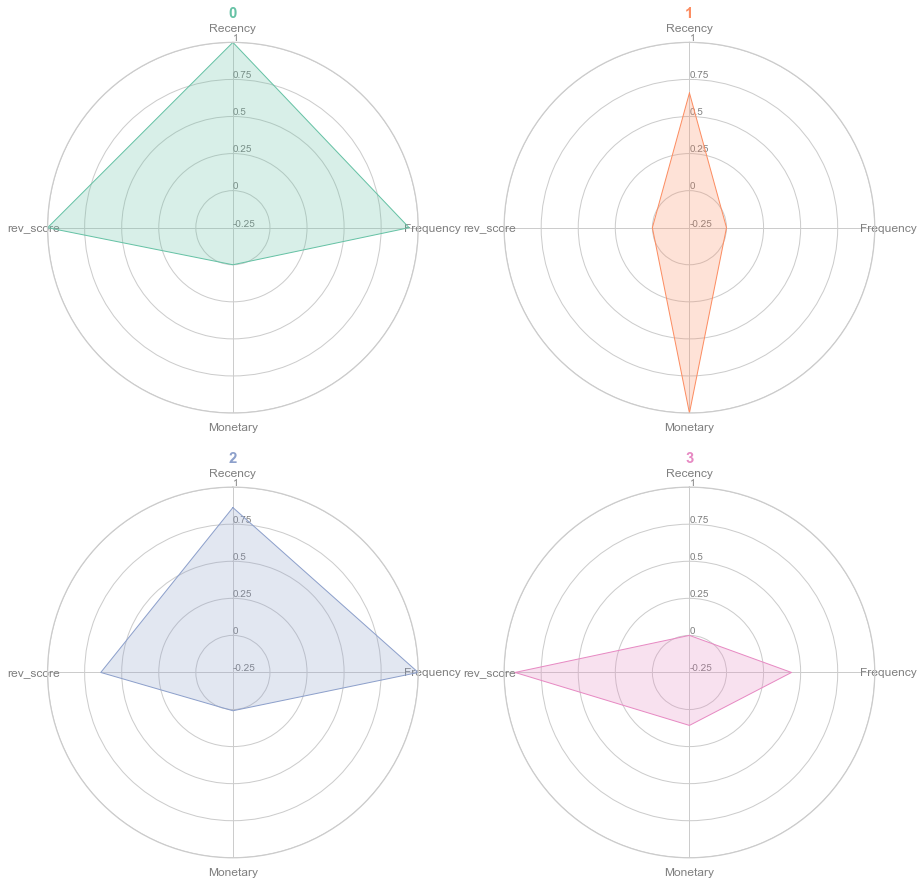

In [524]:
radar_plot(df_RFM_rev_kmeans[0], MinMaxScaler())

plt.savefig("radar plot RFM_rev", dpi=200, bbox_inches='tight')

<AxesSubplot:xlabel='cluster_id', ylabel='rev_score'>

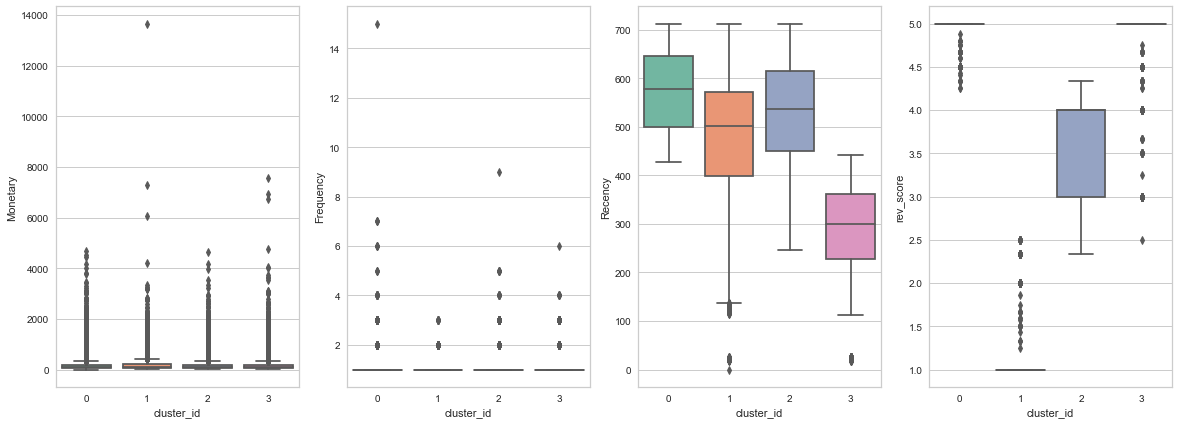

In [531]:

fig = plt.figure(1, figsize=(20, 7))

plt.subplot(141)

sns.boxplot(x='cluster_id', y='Monetary', data = df_RFM_rev_kmeans[1], palette=sns_palette)
# plot
plt.subplot(142)
sns.boxplot(x='cluster_id', y='Frequency', data = df_RFM_rev_kmeans[1], palette=sns_palette)

# plot
plt.subplot(143)
sns.boxplot(x='cluster_id', y='Recency', data = df_RFM_rev_kmeans[1], palette=sns_palette)

plt.subplot(144)

sns.boxplot(x='cluster_id', y='rev_score', data = df_RFM_rev_kmeans[1], palette=sns_palette)



### Pas tres concluant

### Test avec la standarisation StandardScaler

In [514]:
df_RFM_rev_kmeans_std = clustering_result(df_RFM_rev, StandardScaler(), KMeans(n_clusters=K, random_state=0))

Nombre de clusters: 4
Coefficient de Silhouette : 0.40
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_0 : 41986
Nombre de clients par cluster_1 : 32038
Nombre de clients par cluster_2 : 15953
Nombre de clients par cluster_3 : 2778
temps d'execution : 205.25 secondes


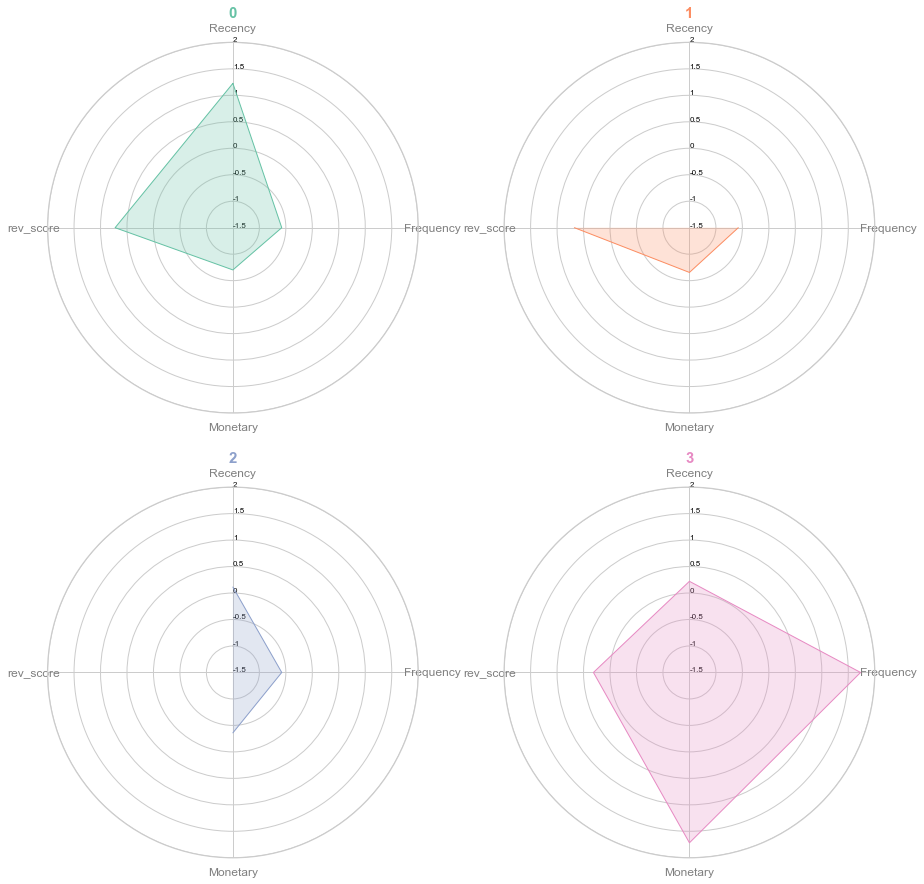

In [525]:
radar_plot_std (df_RFM_rev_kmeans_std[0], StandardScaler())

plt.savefig("radar plot RFM_rev stdscaler", dpi=200, bbox_inches='tight')

## Ajouter les autres attributs

In [652]:
cust_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92755 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Frequency            92755 non-null  int64  
 1   nb_items             92755 non-null  int64  
 2   Recency              92755 non-null  int32  
 3   payment_type         92755 non-null  float64
 4   payment_installment  92755 non-null  float64
 5   rev_score            92755 non-null  float64
 6   SP_State             92755 non-null  float64
 7   Monetary             92755 non-null  float64
dtypes: float64(5), int32(1), int64(2)
memory usage: 6.0+ MB


In [653]:
df_tot = cust_file.copy()

In [654]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, df_tot.columns)])

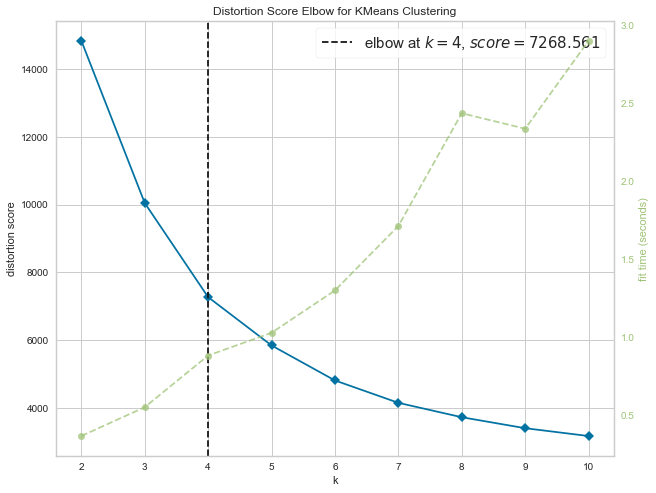

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [483]:

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,15)))])
kmeans_visualizer.fit(df_tot)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [655]:
df_tot_kmeans = clustering_result(df_tot , MinMaxScaler(), KMeans(n_clusters=K, random_state=0))

Nombre de clusters: 4
Coefficient de Silhouette : 0.53
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_0 : 41485
Nombre de clients par cluster_1 : 31703
Nombre de clients par cluster_2 : 12341
Nombre de clients par cluster_3 : 7226
temps d'execution : 105.63 secondes


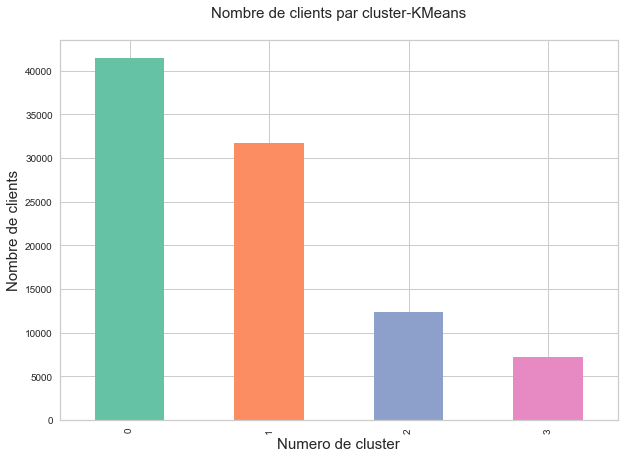

In [656]:


fig = plt.figure(figsize=(10, 7))
ax = plt.axes()

#bar plot

palette = sns.color_palette("Set2", df_tot_kmeans[1]["cluster_id"].nunique())

df_tot_kmeans[1]["cluster_id"].value_counts().sort_index().plot(kind='bar' , color = palette)

ax.set_xlabel("Numero de cluster", fontsize = 15)
ax.set_ylabel("Nombre de clients", fontsize = 15)
plt.title("Nombre de clients par cluster-KMeans\n", fontsize = 15)


 


plt.savefig("Nombre de clients par cluster-KMean++s-tot", dpi=200, bbox_inches='tight')

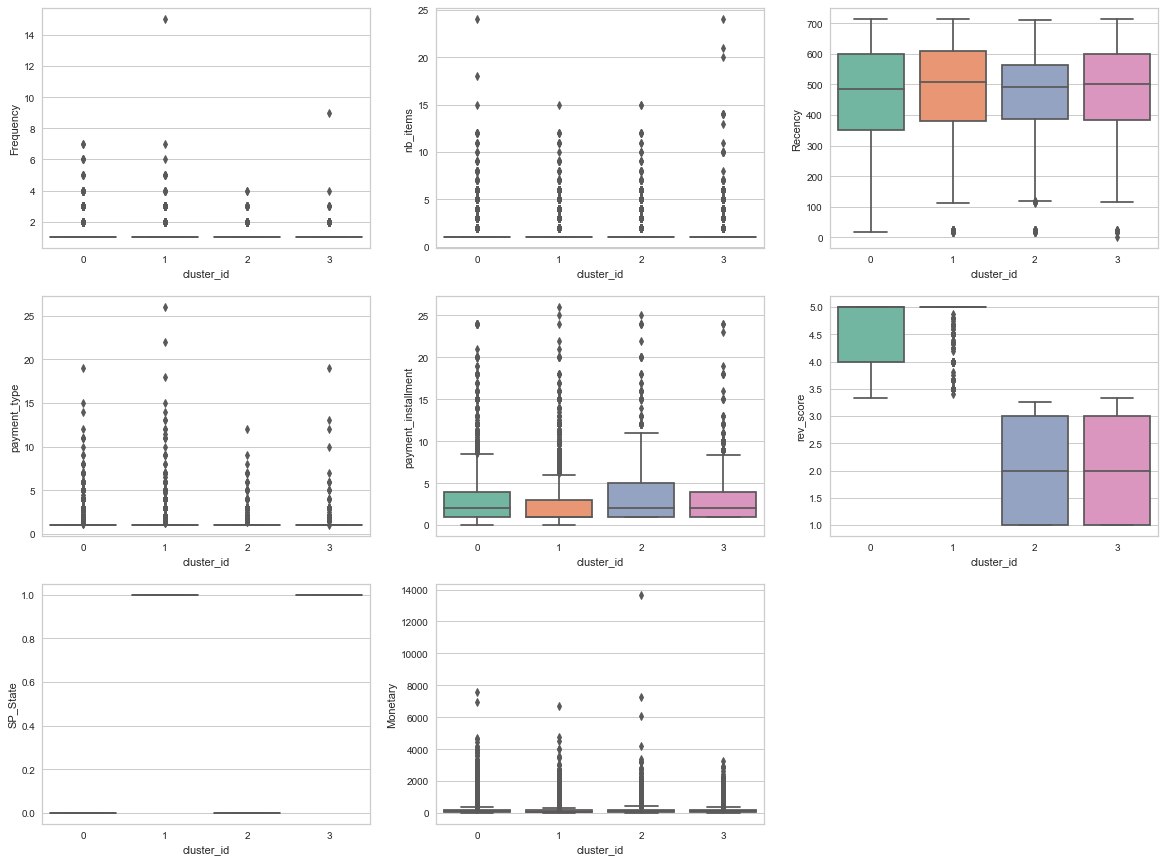

In [699]:
fig = plt.figure(1, figsize=(20, 15))

for col in df_tot_kmeans[1].columns.drop('cluster_id') : 
    i = df_tot_kmeans[1].columns.get_loc(col) + 1
    

    ax = fig.add_subplot(3, 3, i) #plt.subplot(14i)

    ax = sns.boxplot(x='cluster_id', y = col, data = df_tot_kmeans[1], palette = sns_palette)


plt.savefig("boxplot-KMean++s-tot", dpi=200, bbox_inches='tight')
plt.show()




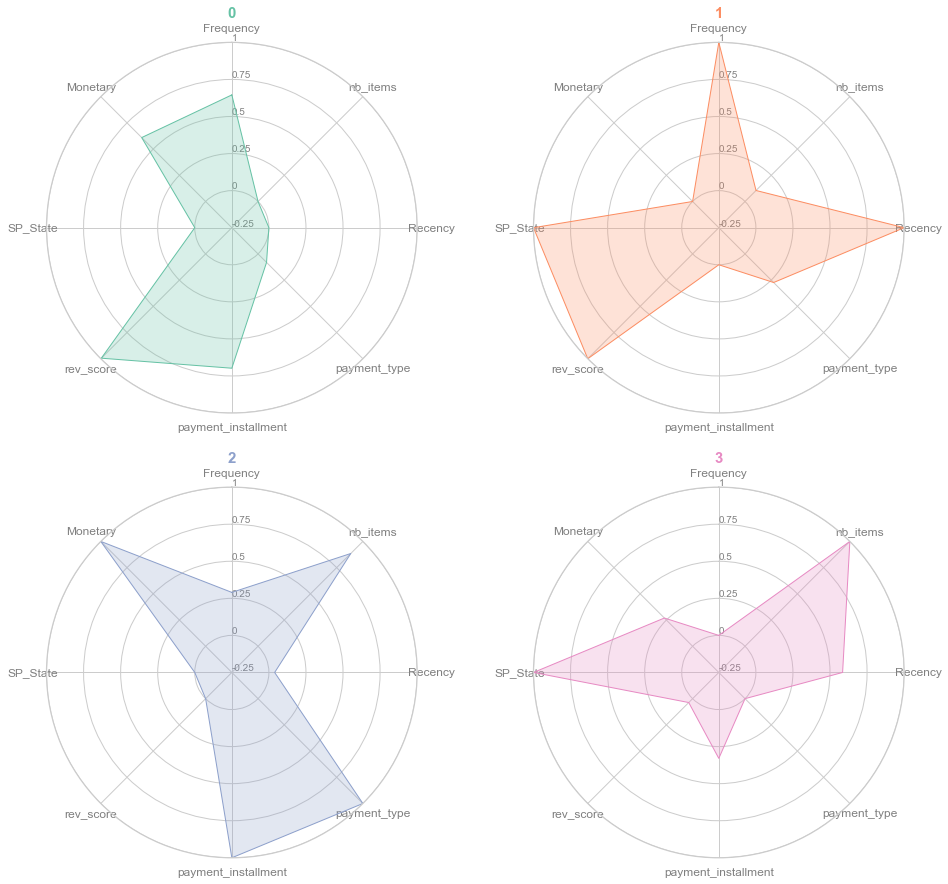

In [700]:
radar_plot(df_tot_kmeans[0], MinMaxScaler())

plt.savefig("radar plot tot", dpi=200, bbox_inches='tight')

Globalement, on obtient presque la meme segmentation que celle de RFM mais avec quelques modifications:

### <font color=#66c2a5> Cluster 0 - Bons clients : achat plus d'une fois pour un bon montant avec un nombre important d'échéances. Ils ne sont pas de SP et Les avis de ces clients sont très bons.
<font color=#66c2a5> Action de développement de la fréquence d'achat et du montant par commande : coupler les actions de fidélisation et les promotions  
    
### <font color=#fc8d62> Cluster 1 - Clients fidèles : ont acheté récemment et fréquemment mais pour un montant faible d'argent qui le regle en une seule échéance. Ils sont de SP et leurs avis sont très bons  
<font color=#fc8d62>  Action d'augmentation de la monétisation en couplant leur fidélisation (une carte premium, invitations VIP, etc.) avec des promotions liées à des seuils de dépenses
    
### <font color=#8da0cb> Cluster 2 - clients inactifs/Perdus : ont acheté plusieurs fois mais pas recémment. Ils ont payé une somme importante d'argent pour plusieurs produits avec plusieurs moyens de paiement et un nombre important d'échéances. Ils ont eu des mauvaises experiences et ils sont mecontents  
<font color=#8da0cb> Action : Il faut les recuperer en les reconciliant. Demander aux sellers de repondre a leurs avis négatifs et de les récompenser avec des bons de réductions conséquents. 
    
### <font color=#e78ac3> Cluster 3 : Nouveaux clients : ont acheté récemment plusieurs produits, une fois mais pour un faible montant et avec un nombre faible d'échéances. Ils sont de SP et ils sont mécontents.
<font color=#e78ac3> Action : Action de fidélisation et de reconciliation. Recommandations de produits basées sur des achats antérieurs avec des bons de reductions 


La localisation a  Saint paulo n'apporte pas des informations pertinentes pour la segmentation. Si je l'enleve est ce que cela affectera l'interpretation de la segmentation?

In [701]:
df_tot_nSP = cust_file.copy().drop('SP_State', axis=1)

In [702]:
df_tot_kmeans_nSP = clustering_result(df_tot_nSP , MinMaxScaler(), KMeans(n_clusters=K, random_state=0))

Nombre de clusters: 4
Coefficient de Silhouette : 0.40
Nombre de clients sans cluster (noise) : 0
Nombre de clients par cluster_3 : 35407
Nombre de clients par cluster_1 : 25367
Nombre de clients par cluster_0 : 20160
Nombre de clients par cluster_2 : 11821
temps d'execution : 108.42 secondes


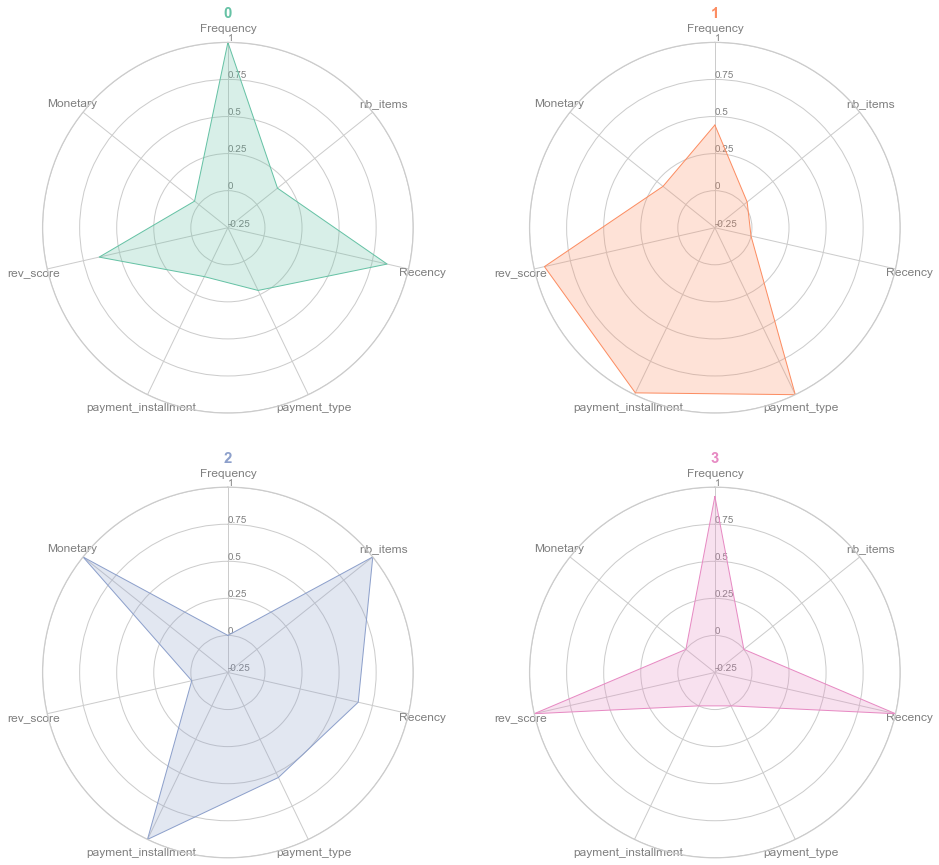

In [703]:
radar_plot(df_tot_kmeans_nSP[0], MinMaxScaler())

plt.savefig("radar plot tot nSP", dpi=200, bbox_inches='tight')

La segmentation n'est pas meilleure pour l'explication des segments. Je garde celle precedente comme resultat final

## Reduction dimensions avec T-SNE

--- %s seconds ---688.7630848884583


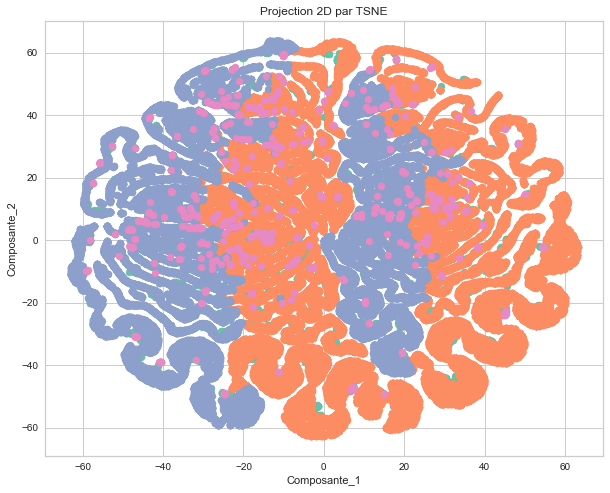

In [613]:
tsne_graph(df_tot, MinMaxScaler(), KMeans(n_clusters = 4, random_state=0))

plt.savefig('TSNE tot', dpi=200, bbox_inches='tight')
plt.show()


--- %s seconds ---752.1341416835785


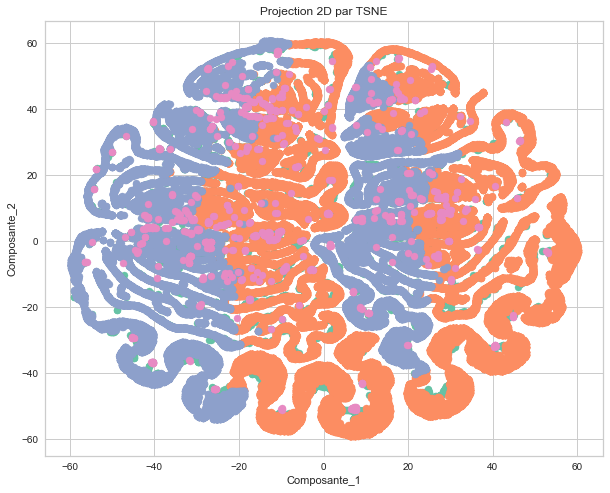

In [620]:
tsne_graph(df_tot, MinMaxScaler(), KMeans(n_clusters = 4, random_state=0), perplex = 50)

plt.savefig('TSNE tot perp 50', dpi=200, bbox_inches='tight')
plt.show()

Avec la reduction de dimensions T-SNE, les clusters obtenus ne sont pas bien separes meme en variant le niveau de perplexite.